In [1]:
import leaderbot as lb
import numpy
import numpy as np
import matplotlib.pyplot as plt
import texplot
import time
import scipy

In [2]:
data = lb.data.load()

models = numpy.array(data['models'])
xs = numpy.array(data['X'])
ys = numpy.array(data['Y'])
n_models = len(models)

In [3]:
wins, losses, ties = ys[:, 0], ys[:, 1], ys[:, 2]

n_wins = numpy.zeros((n_models,), dtype=int)
n_losses = numpy.zeros((n_models,), dtype=int)
n_ties = numpy.zeros((n_models,), dtype=int)
n_games = numpy.zeros((n_models,), dtype=int)

for i in range(n_models):
    ind_0 = (xs[:, 0] == i)
    ind_1 = (xs[:, 1] == i)
    n_wins[i] = numpy.sum(wins[ind_0]) + numpy.sum(losses[ind_1])
    n_losses[i] = numpy.sum(losses[ind_0]) + numpy.sum(wins[ind_1])
    n_ties[i] = numpy.sum(ties[ind_0]) + numpy.sum(ties[ind_1])

n_games = n_wins + n_losses + n_ties
p_wins = n_wins / n_games
p_losses = n_losses / n_games
p_ties = n_ties / n_games

In [4]:
alg = lb.models.DavidsonScaled(data)

In [5]:
# Local optimizations
#methods = ['BFGS', 'L-BFGS-B', 'CG', 'Newton-CG', 'TNC', 'Nelder-Mead', 'shgo', 'basinhopping']
methods = ['BFGS', 'L-BFGS-B']
benchmark = 0 # choose which model to be the default for the rest of analysis
results = []

for method in methods:
    t0 = time.time()
    w = alg.train(method=method)
    t = time.time() - t0

    res = alg._result
    results.append(res)

    print(f'{method:>12} | nit: {res.nit:>4}, nfev: {res.nfev:>4}, ', end='')
    if hasattr(res, 'njev'):
        print(f'njev: {res.njev:>5} | ', end='')
    else:
        print('njev:     0 | ', end='')
    if hasattr(res, 'jac'):
        print(f'time: {t:>6.2f} | '
              f'fun: {res.fun:>0.6f}, jac: {numpy.mean(numpy.abs(res.jac)):>0.1e}')
    else:
        print(f'time: {t:>6.2f} | '
              f'fun: {res.fun:>0.6f}, jac: None')

        BFGS | nit: 1500, nfev: 1527, njev:  1527 | time:  28.86 | fun: 1.007459, jac: 3.2e-05
    L-BFGS-B | nit: 1500, nfev: 1765, njev:  1765 | time:   7.20 | fun: 1.011516, jac: 1.6e-04


        BFGS | constraint scores: +5.1e-11, constraint scales: -1.4e-09
    L-BFGS-B | constraint scores: +3.1e-05, constraint scales: +1.1e-04
          CG | constraint scores: -8.3e-07, constraint scales: +3.1e-06


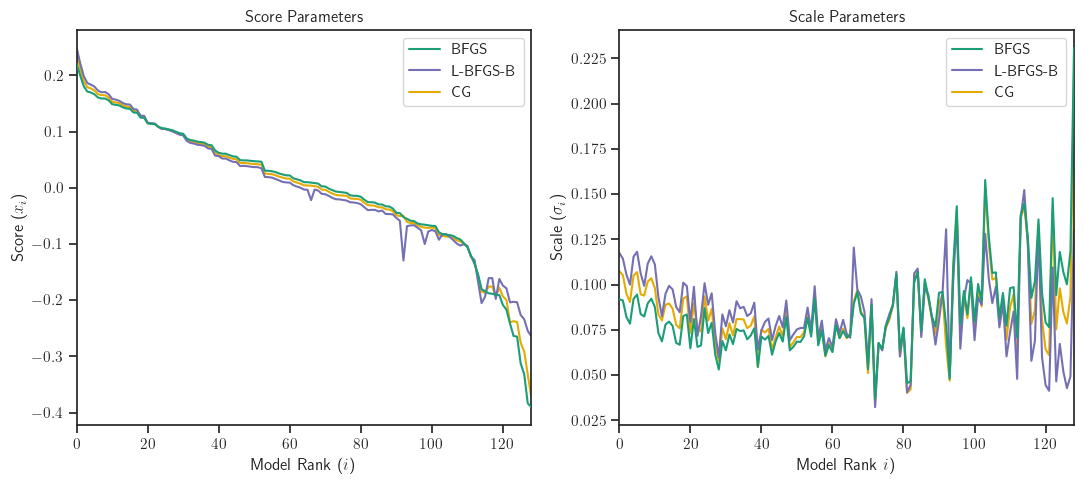

In [6]:
#%matplotlib tk
with texplot.theme():
    fig, ax = plt.subplots(ncols=2, figsize=(11, 5))
    
    cmap = plt.cm.Dark2
    
    n_methods = len(methods)
    
    scores = results[benchmark].x[:n_models]
    rank = numpy.argsort(scores)[::-1]
    
    for i in range(n_methods):
        scores = numpy.array(results[i].x)[:n_models][rank]
        scales = numpy.abs(numpy.array(results[i].x)[n_models:2*n_models])[rank]
        ax[0].plot(scores, label=methods[i], color=cmap(i/n_methods), zorder=n_methods-i)
        ax[1].plot(scales, label=methods[i], color=cmap(i/n_methods), zorder=n_methods-i)
    
        print('%12s | constraint scores: %+0.1e, constraint scales: %+0.1e'
              % (methods[i], numpy.sum(scores), numpy.sum(scales**2)-1))
    
    ax[0].set_xlim([0, n_models-1])
    ax[0].legend()
    
    ax[1].set_xlim([0, n_models-1])
    ax[1].legend()

    ax[0].set_xlabel(r'Model Rank ($i$)')
    ax[1].set_xlabel(r'Model Rank $i$)')
    ax[0].set_ylabel(r'Score ($x_i$)')
    ax[1].set_ylabel(r'Scale ($\sigma_i$)')
    ax[0].set_title('Score Parameters')
    ax[1].set_title('Scale Parameters')
    
    plt.tight_layout()

plt.show()

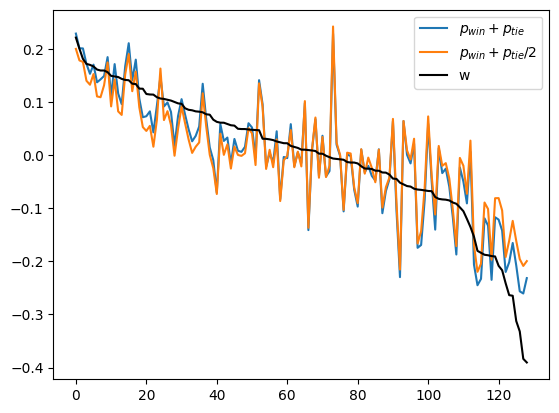

In [7]:
a = p_wins + p_ties
b = p_wins + p_ties / 2.0
#a = numpy.log(a)
a = a - numpy.nanmean(a)
b = b - numpy.nanmean(b)

scores = numpy.array(results[benchmark].x)[:n_models][rank]
plt.plot(a[rank], label=r'$p_{win} + p_{tie}$')
plt.plot(b[rank], label=r'$p_{win} + p_{tie}/2$')
plt.plot(scores, label='w', color='black')
plt.legend()
plt.show()

# MDS

In [6]:
w1 = results[benchmark].x
xi = w1[:n_models]
ti = w1[n_models:2*n_models]
rij = w1[2*n_models:]

# S is Covariance

S = numpy.zeros((n_models, n_models))
for j in range(n_models):
    for i in range(j, n_models):
        if i == j:
            S[i, i] = ti[i]**2
        else:
            k = j*(j-1)//2 + i
            #S[i, j] = numpy.abs(ti[i] * ti[j]) * numpy.tanh(rij[k])
            S[i, j] = 0.0
            S[j, i] = S[i, j]

# double-centering operator C
v = numpy.ones((n_models, 1))
C = numpy.eye(n_models) - v @ v.T / n_models

# B is double-centering Gram matrix
B = C @ S @ C

In [13]:
e, V = numpy.linalg.eigh(B)
ind = numpy.argsort(e)[::-1]
e = e[ind]
e[numpy.abs(e) < 1e-08] = 0
V = V[:, ind]
Z = numpy.diag(numpy.sqrt(e))
W = V @ Z

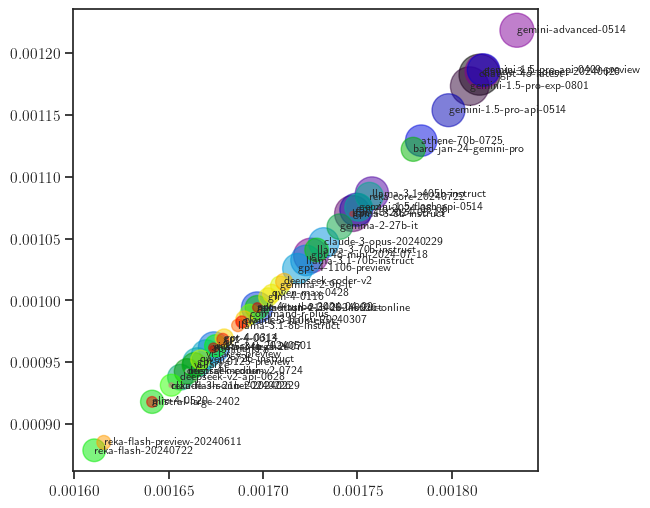

In [14]:
n = 50
rank = numpy.argsort(xi)[::-1]
x = W[rank[:n], 0]
y = W[rank[:n], 1]
z = W[rank[:n], 2]

num_points = x.size
colors = np.linspace(0, 1, n)
sizes = [5000 * (xi[rank[i]] - xi[rank[n]]) + 100*xi[rank[n]] for i in range(n)]

#%matplotlib tk
#%matplotlib inline
with texplot.theme():
    fig, ax = plt.subplots(figsize=(6, 6))
    ax.scatter(x, -y, s=sizes, c=colors, cmap='nipy_spectral', alpha=0.5)
    for i in range(n):
        ax.text(x[i], -y[i], models[rank[i]], fontsize=8, ha='left', va='center')
    
    #plt.xscale('log')
    #plt.yscale('log')
    #ax.set_aspect('equal', adjustable='box')
plt.show()

In [19]:
%matplotlib tk
with texplot.theme(use_latex=False):
    fig = plt.figure(figsize=(8, 8))
    ax = fig.add_subplot(projection='3d')
    ax.set_proj_type('persp', focal_length=0.2)
    
    ax.scatter(x, y, z, s=sizes, c=colors, cmap='nipy_spectral', alpha=0.5)

    for i  in range(n):
        ax.text(x[i], y[i], z[i], models[rank[i]], fontsize=8, ha='center', va='center')
    
    #for i in range(4):
    #    ax.plot(W[i, 0], W[i, 1], W[i, 2], 'o')
    #    #ax.plot(W[0, i], W[1, i], W[2, i], 'o')
    
    ax.set_xlabel(r'$x$')
    ax.set_ylabel(r'$y$')
    ax.set_zlabel(r'$z$')
    
    ax.xaxis.pane.set_edgecolor('black')  # Set edge color
    ax.yaxis.pane.set_edgecolor('black')
    ax.zaxis.pane.set_edgecolor('black')
    
    ax.xaxis.pane.set_linewidth(1)  # Set edge line width
    ax.yaxis.pane.set_linewidth(1)
    ax.zaxis.pane.set_linewidth(1)
    
    ax.view_init(elev=5, azim=65, roll=0)

plt.show()

# MDS and Kernel PCA

In [7]:
# Distance matrix
D = numpy.zeros((n_models, n_models))

for i in range(n_models):
    for j in range(n_models):
        #D[i, j] = numpy.sqrt(sca[i]**2 + sca[j]**2)
        #D[i, j] = numpy.sqrt(T[i, i] + T[j, j] - 2*T[i, j])
        if i == j:
            D[i, j] = 0.0
        else:
            #D[i, j] = numpy.abs(xi[i] - xi[j]) / numpy.sqrt(B[i, i] + B[j, j] - 2*B[i, j])
            D[i, j] = numpy.abs(xi[i] - xi[j]) / numpy.sqrt(S[i, i] + S[j, j] - 2*S[i, j])
            #D[i, j] = numpy.sqrt(B[i, i] + B[j, j] - 2*B[i, j])
            #D[i, j] = numpy.sqrt(S[i, i] + S[j, j] - 2*S[i, j])
            #D[i, j] = numpy.abs(xi[i] - xi[j])

In [8]:
from sklearn.manifold import MDS
from sklearn.decomposition import KernelPCA

In [22]:
# MDS method
mds = MDS(n_components=3, dissimilarity='precomputed', random_state=42)
points = mds.fit_transform(D)

# 3D visualization settings
elev, azim, roll = 8, 115, 0

In [11]:
# Kernel PCA
gamma = 1e-4  # You might need to adjust gamma based on your data
kernel_matrix = np.exp(-gamma * D ** 2)
kpca = KernelPCA(n_components=3, kernel='precomputed')
points = kpca.fit_transform(kernel_matrix)

# 3D visualization settings
elev, azim, roll = 8, 145, 0

In [27]:
# Plot 2D

rank = numpy.argsort(xi)[::-1]
points_ranked = points[rank]
models_ranked = models[rank]
score = xi[rank]

n = 40

sizes = [5000 * (score[i] - score[n]) + 100 * score[n] for i in range(n)]
colors = np.linspace(0, 1, n)

with texplot.theme():
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.scatter(-points_ranked[:n, 0], points_ranked[:n, 1], s=sizes, c=colors,
               cmap='turbo_r', alpha=0.55)
    for i, name in enumerate(models_ranked[:n]):
        ax.text(-points_ranked[i, 0], points_ranked[i, 1], name, fontsize=8, ha='center',
                va='center')
    
    #ax.set_aspect('equal', adjustable='box')
    #ax.set_xlim([-0.021, 0])
    #ax.set_ylim([-0.005, 0.0125])

plt.show()

In [80]:
type(c_map)

matplotlib.colors.LinearSegmentedColormap

In [12]:
# Plot 3D
rank = numpy.argsort(xi)[::-1]
points_ranked = points[rank]
models_ranked = models[rank]
score = xi[rank]

n = 40
fontsize = 10

import colorcet as cc

c_map = 'turbo_r'
c_map = 'gist_rainbow'
c_map = 'jet_r'
c_map = cc.cm.CET_R2_r
c_map = cc.cm.CET_R4_r
#c_map = 'nipy_spectral_r'
#c_map = 'gnuplot2_r'

sizes = [5000 * (score[i] - score[n]) + 100 * score[n] for i in range(n)]
colors = np.linspace(0, 1, n)

#%matplotlib tk
#%matplotlib inline
%config InlineBackend.print_figure_kwargs = {'bbox_inches':None}
#%matplotlib notebook
with texplot.theme():

    #fig, ax = plt.subplots(figsize=(10, 10))
    #fig = plt.figure(figsize=(8, 8))
    #ax = fig.add_subplot(projection='3d')
    fig, ax = plt.subplots(figsize=(8, 6.5), subplot_kw={'projection': '3d'},
                       gridspec_kw=dict(top=1.28, bottom=0.06, left=-0.08, right=0.9))
    
    
    ax.set_proj_type('persp', focal_length=0.17)
    
    ax.scatter(points_ranked[:n, 0], -points_ranked[:n, 1], -points_ranked[:n, 2],
               s=sizes, c=colors,
               cmap=c_map,
               alpha=0.8,
               edgecolor=(0.0, 0.0, 0.0, 0.0),
               #edgecolor=None,
               linewidth=0.6
              )

    
    for i, name in enumerate(models_ranked[:n]):
        ax.text(points_ranked[i, 0], -points_ranked[i, 1], -points_ranked[i, 2],
                name, fontsize=fontsize, ha='center', va='center')
    
    
    
    # Remove tick labels
    #ax.set_xticks([])
    #ax.set_yticks([])
    #ax.set_zticks([])
    
    #ax.grid(False)
    
    ax.set_xlabel(r'$X_1$')
    ax.set_ylabel(r'$X_2$')
    ax.set_zlabel(r'$X_3$')
    
    # Remove axis panes (background of the plot)
    #ax.xaxis.pane.fill = False
    #ax.yaxis.pane.fill = False
    #ax.zaxis.pane.fill = False
    
    ax.xaxis.pane.set_edgecolor('black')  # Set edge color
    ax.yaxis.pane.set_edgecolor('black')
    ax.zaxis.pane.set_edgecolor('black')
    
    ax.xaxis.pane.set_linewidth(1.5)  # Set edge line width
    ax.yaxis.pane.set_linewidth(1.5)
    ax.zaxis.pane.set_linewidth(1.5)
    
    #plt.subplots_adjust(left=0.05, right=0.8, top=0.8, bottom=0.3)
    
    #plt.tight_layout()
    #ax.set_position([-0.2, -0.1, 0.7, 0.9])  # [left, bottom, width, height]
    
    # Ensure equal aspect ratio for the axes
    #ax.set_box_aspect([1, 1, 0.5])
    
    ax.view_init(elev=elev, azim=azim, roll=roll)
    
    #ax.margins(x=0.2, y=0.00, z=0.2)
    
    eps = 0.0006
    x_min = np.min(points_ranked[:n, 0]) - eps
    x_max = np.max(points_ranked[:n, 0]) + eps
    y_min = np.min(-points_ranked[:n, 1]) - eps
    y_max = np.max(-points_ranked[:n, 1]) + eps
    z_min = np.min(-points_ranked[:n, 2]) - eps
    z_max = np.max(-points_ranked[:n, 2]) + eps
    
    ax.axes.set_xlim3d(left=x_min, right=x_max)
    ax.axes.set_ylim3d(bottom=y_min, top=y_max)
    ax.axes.set_zlim3d(bottom=z_min, top=z_max)
    
    #fig.set_size_inches(8, 8)
    #plt.subplots_adjust(left=0, right=0.9, top=1, bottom=0.1)
    #plt.subplots_adjust(left=0, right=1, top=1.4, bottom=0)
    
    #ax.set_box_aspect(aspect=(4, 4, 3), zoom=1)
    #plt.subplots_adjust(left=0, right=1, top=1.0, bottom=0.0)
    
    #plt.subplots_adjust(left=0, right=1, top=1, bottom=0)
    
    #plt.show()
    # fig.tight_layout(pad=40)
    
    fig.canvas.draw()

# Goodness of Fit

In [21]:
w1 = results[benchmark].x
xi = w1[:n_models]
ti = numpy.abs(w1[n_models:2*n_models])
rank = numpy.argsort(xi)[::-1]

y_pred = model.inference(w1)

In [22]:
def cross_entropy(p, q):
    h = p * numpy.log(q)
    h[p == 0] = 0
    return h

# Jensen-Shannon Divergence
ys_sum = ys.sum(axis=-1, keepdims=True)
ys_sum[ys_sum == 0] = 1.0
ys_ = ys / ys_sum
m = (y_pred + ys_) / 2
js = 0.5 * (cross_entropy(ys_, ys_ / m) + cross_entropy(y_pred, y_pred / m))
js = js.sum(axis=-1)
js_mean = numpy.mean(js)
js_std = numpy.std(js)

print(f'js: {js_mean:>0.4f} +-({js_std:>0.4f})')

js: 0.0092 +-(0.0307)


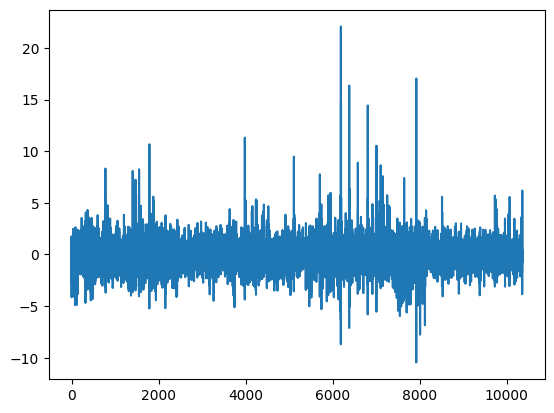

In [23]:
f_obs = ys
f_exp = numpy.sum(ys, axis=1, keepdims=True) * y_pred
ddof = 2*n_models+1 - (1+1)

f_obs = f_obs.ravel()
f_exp = f_exp.ravel()

res = (f_obs - f_exp) / numpy.sqrt(f_exp)

plt.plot(res)
plt.show()

In [24]:
# Observations
wins, losses, ties = ys[:, 0], ys[:, 1], ys[:, 2]

n_wins = numpy.zeros((n_models,), dtype=int)
n_losses = numpy.zeros((n_models,), dtype=int)
n_ties = numpy.zeros((n_models,), dtype=int)
n_games = numpy.zeros((n_models,), dtype=int)

for i in range(n_models):
    ind_0 = (xs[:, 0] == i)
    ind_1 = (xs[:, 1] == i)
    n_wins[i] = numpy.sum(wins[ind_0]) + numpy.sum(losses[ind_1])
    n_losses[i] = numpy.sum(losses[ind_0]) + numpy.sum(wins[ind_1])
    n_ties[i] = numpy.sum(ties[ind_0]) + numpy.sum(ties[ind_1])

n_games = n_wins + n_losses + n_ties
p_wins = n_wins / n_games
p_losses = n_losses / n_games
p_ties = n_ties / n_games

# Predictions
n_pred = numpy.sum(ys, axis=1, keepdims=True) * y_pred

wins_pred, losses_pred, ties_pred = n_pred[:, 0], n_pred[:, 1], n_pred[:, 2]

n_wins_pred = numpy.zeros((n_models,), dtype=float)
n_losses_pred = numpy.zeros((n_models,), dtype=float)
n_ties_pred = numpy.zeros((n_models,), dtype=float)

#numpy.sum(ys, axis=1, keepdims=True) * y_pred

for i in range(n_models):
    ind_0 = (xs[:, 0] == i)
    ind_1 = (xs[:, 1] == i)
    n_wins_pred[i] = numpy.sum(wins_pred[ind_0]) + numpy.sum(losses_pred[ind_1])
    n_losses_pred[i] = numpy.sum(losses_pred[ind_0]) + numpy.sum(wins_pred[ind_1])
    n_ties_pred[i] = numpy.sum(ties_pred[ind_0]) + numpy.sum(ties_pred[ind_1])

n_games_pred = n_wins_pred + n_losses_pred + n_ties_pred
p_wins_pred = n_wins_pred / n_games_pred
p_losses_pred = n_losses_pred / n_games_pred
p_ties_pred = n_ties_pred / n_games_pred

In [25]:
f_obs = numpy.array([n_wins, n_losses, n_ties]).T
f_exp = numpy.array([n_wins_pred, n_losses_pred, n_ties_pred]).T

f_obs = f_obs.ravel()
f_exp = f_exp.ravel()
scale = (f_obs.size - 2*n_models - 1)

st, p_value = scipy.stats.power_divergence(f_obs/scale, f_exp/scale, ddof=0, lambda_=1)
print(st)
print(p_value)

76.37731335285194
1.0


In [26]:
from scipy.stats import shapiro, kstest
stat, p_value = kstest(f_obs - f_exp, 'norm')
print(stat)
print(p_value)

0.5502984705771449
1.3609985122381368e-110


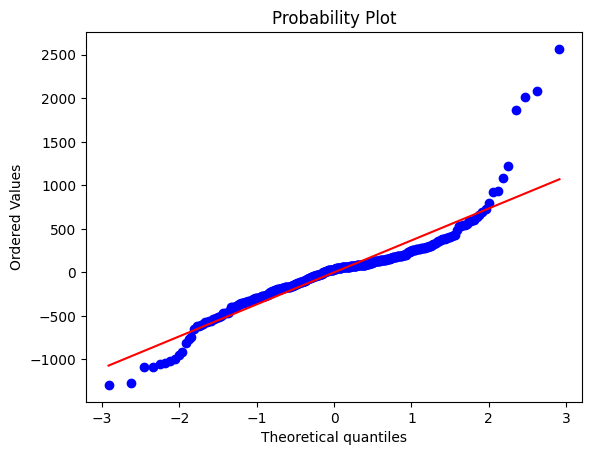

In [27]:
from scipy import stats
stats.probplot(f_obs - f_exp, dist=stats.norm, plot=plt)
plt.show()

In [28]:
a = (f_obs - f_exp)**2 / f_exp
#a = 2 * f_obs * numpy.log(f_obs / f_exp)
print(numpy.sum(a))

9776.296109165049


In [29]:
numpy.sum(a) / a.size

np.float64(25.26174705210607)

In [30]:
ys.shape

(3455, 3)

# Gumbel Distributions

This should only be used when the covariance matrix is diagonal and with no ties (basically `bradleyterry_scale.py`)

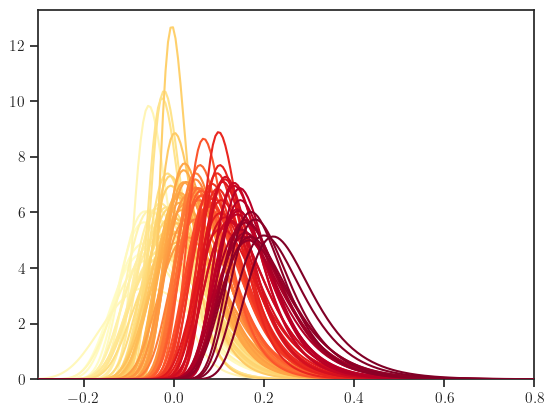

In [33]:
w1 = results[benchmark].x
xi = w1[:n_models]
ti = w1[n_models:2*n_models]
rank = numpy.argsort(xi)[::-1]

x = numpy.linspace(-0.3, 0.8, 200)

cmap = plt.cm.YlOrRd_r
n = 100

with texplot.theme():
    for i in range(0, n, 1):

        mu = xi[rank[i]]
        sigma = ti[rank[i]]
    
        # Normal distribution
        y1 = 1/(numpy.sqrt(2*numpy.pi) * sigma) * numpy.exp(-0.5 * ((x-mu)/sigma)**2)
    
        # Gumbel distribution
        beta = sigma * numpy.sqrt(6) / numpy.pi
        z = (x-mu)/beta
        y2 = numpy.exp(-(z + numpy.exp(-z)))/beta
        
        #plt.plot(x, y1)
        plt.plot(x, y2, color=cmap(i/n), zorder=n-i)

plt.ylim(bottom=0)
plt.xlim([x[0], x[-1]])
plt.show()